# Niveaux intermédiaires avec sigmoïde

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

Ajout de couches de neurones intermédiaires avec sigmoïde comme fonction d'activation. La dernière couche de neurones reste la même que précédemment avec softmax.

<img src="NN_sigmoid.png"  style="width: 60%; height: 60%"/>

La fonction sigmoïde permet d'avoir un signal en sortie de neurone toujours compris entre 0 et 1.

$$\forall x \in \mathbb R,$$
$$\sigma(x)=\frac{1}{1+e^{-x}}$$

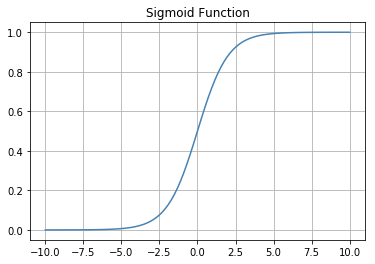

In [14]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
x=np.linspace(-10,10,100)
plt.plot(x, sigmoid(x), 'steelblue')
plt.grid()
plt.title('Sigmoid Function')
plt.show()

## Données

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.
x_test  = x_test/255.
y_train = to_categorical(y_train, dtype='int8')
y_test  = to_categorical(y_test, dtype='int8')

## Définition du graphe

On reprend la solution précédente en ajoutant deux niveaux intermédiaires. Un niveau de 200 neurones complètement connecté au vecteur d'entrée X et un second de 100 neurones complètement connecté au précédent. Dans les deux cas la fonction d'activation est la sigmoïde (quoi qu'à l'heure actuelle la littérature semble indiquer que la solution la plus pertinente soit la fonction ReLU (pour retified linear unit), mais cette solution sera présentée par la suite. On aura donc pour chaque sous niveau:
$$Y = \sigma(WX+b)$$

L'initialisation des poids ne se fait plus à zéros, sinon on a un comportement aléatoire avec une convergence dégradée et des performaces qui le sont tout autant!

<img src="init_zero.png" style="width: 50%; height: 50%"/>

Pour éviter ce comportement un utilise une initialisation avec des poids alétoires de petite taille en suivant une distribution gaussienne grace à la fonction `tf.truncated_normal` qui renvoie des chiffres entre  -2*(écart type) et +2*(écart type). (écart type = standard deviation, stddev)

Premier niveau de 200 neurones:
- en entrée X[batch_size,784]
- neurones W1[784,200] b1[200]
- en sortie Y1[batch_size,200]

In [16]:
X = tf.placeholder(tf.float32, shape=(None,28,28))
Xv = tf.reshape(X, [-1, 784])

> tf.placeholder, tf.constant sont des noeuds du graphe (des opérations) et commencent avec une minuscule, tandis que tf.Variable correspond à une classe

In [17]:
#W1 = tf.Variable(tf.zeros([784,200]))
W1 = tf.Variable(tf.truncated_normal([784,200], stddev=0.1))
b1 = tf.Variable(tf.zeros([200]))

In [18]:
Y1 = tf.nn.sigmoid(tf.matmul(Xv,W1) + b1)

Deuxième niveau de 100 neurones:
- en entrée Y1[batch_size,200]
- neurones W2[200,100] b2[100]
- en sortie Y2[batch_size,100]

In [19]:
#W2 = tf.Variable(tf.zeros([200,100]))
W2 = tf.Variable(tf.truncated_normal([200,100], stddev=0.1))
b2 = tf.Variable(tf.zeros([100]))
Y2 = tf.nn.sigmoid(tf.matmul(Y1,W2) + b2)

Troisième niveau: 10 neurones avec softmax:
- en entrée Y2
- neurones W3[100,10], b3[10]
- en sortie Y[batch_size,10]

In [20]:
#W3 = tf.Variable(tf.zeros([100, 10]))
W3 = tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))
b3 = tf.Variable(tf.zeros([10]))
Y = tf.nn.softmax(tf.matmul(Y2,W3) + b3)

In [21]:
Y_ = tf.placeholder(tf.float32, shape=(None,10))

Entropie croisée:

In [22]:
cross_entropy = - tf.reduce_sum(Y_ * tf.log(Y))
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
optimizer = tf.train.GradientDescentOptimizer(0.003)
train_step = optimizer.minimize(cross_entropy)

## Phase d'apprentissage

In [23]:
n_train = x_train.shape[0] # Nombre de ligne de la matrice x_train
n_test  = x_test.shape[0]
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
i_best = 0
accuracy_best = 0

Epoch :  1
Epoch :  2
Epoch :  3
Epoch :  4
Epoch :  5
Epoch :  6
Epoch :  7
Epoch :  8
Epoch :  9


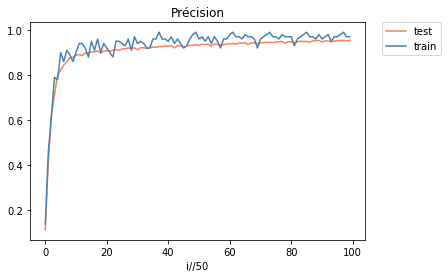

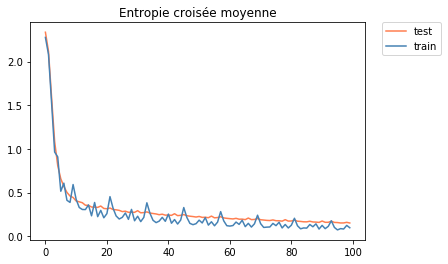

Best score for iteration 4800 	| Accuracy = 0.9539


In [24]:

sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)


for i in range(5000):
    epoch = (i*100)//n_train + 1
    
    # Chargement d'un batch d'images et de réponses correctes correspondantes
    batch_train_X  = x_train[(i*100)%n_train:((i+1)*100)%n_train]
    batch_train_Y_ = y_train[(i*100)%n_train:((i+1)*100)%n_train]
    # Dictionnaire de données en entrée
    train_data = {X: batch_train_X, Y_: batch_train_Y_}

    # train
    sess.run(train_step, feed_dict=train_data)
    
    # Visualisation de la progression
    if not (i*100)%(n_train):
        print("Epoch : ", epoch)
    if not i%50:
        # Pour le batch d'entraînement
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=train_data)
        accuracy_train.append(acc)
        loss_train.append(loss/100)
        
        # Pour le test: évaluation sur tout l'ensemble des données
        #batch_test_X  = x_train[:n_test]
        #batch_test_Y_ = y_train[:n_test]
        test_data = {X: x_test, Y_: y_test}
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
        accuracy_test.append(acc)
        loss_test.append(loss/n_test)
        if acc>accuracy_best:
            accuracy_best = acc
            i_best = i

# Représentation des résultats
# Précision
plt.plot(accuracy_test, c='coral', label='test')
plt.plot(accuracy_train, c='steelblue', label='train')
plt.xlabel('i//50')
plt.title('Précision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Fonction de coût
plt.plot(loss_test, c='coral', label='test')
plt.plot(loss_train, c='steelblue', label='train')
plt.title('Entropie croisée moyenne')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Meilleur résultat sur un batch de test
print("Best score for iteration {} \t| Accuracy = {:.4f}".format(i_best, accuracy_best ))


Déjà 95,39% de réussite sur l'ensemble de test! Impressionant :)

In [25]:
sess.close()